In [3]:
import numpy as np
import matplotlib.pyplot as plt

from tictactoe import TicTacToe

# Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
 - Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
 - Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.


Код, реализующий Q-обучение, реализован в модуле `q_agent.py`.

Основная сложность, встретившаяся в задании - обучение сети в условиях хода соперника сразу для каждого из них. Для этого в памяти сохранялся ход, который привел к соответствующему ходу соперника (т.е. Q-функция обучалась не на прошлый ход матча, а на прошлый ход соответствующего игрока).

In [2]:
from q_agent import QAgent

Для этого и использованных в дальнейшем методов используется схожий синтаксис - вызывается метод learn, в котором сохраняются промежуточные результаты расчетов. В дальнейшем они отрисовываются следующей функцией:

In [5]:
def plot_results(agent, result):
    random_results = agent.play(n_episodes=2000, random_x=True, random_o=True)

    n_iter = [0] + result.iter
    x_wins = [random_results[1]]
    o_wins = [random_results[-1]]

    for scores in result.x:
        x_wins.append(scores[1])
    
    for scores in result.o:
        o_wins.append(scores[-1])

    plt.plot(n_iter, x_wins, label='X')
    plt.plot(n_iter, o_wins, label='O')
    plt.ylim(0, 1.01)
    plt.legend()
    plt.xlabel("Count of iterations")
    plt.ylabel("Side winrate")
    plt.grid(True)

Посмотрим, как работает Q-обучение на доске 3х3. Здесь и далее будем изображать долю побед каждого из игроков против случайного соперника.

Final X win rate:  0.985
Final O win rate:  0.822


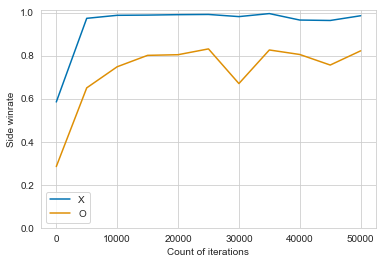

In [6]:
agent = QAgent()
result = agent.learn(n_train_episodes=50000, n_test_episodes=1000, verbose=5000, min_eps=0.1)
plot_results(agent, result)

Исходя из результатов, агент что-то знает об игре. Крестики выигрывают практически всегда (кроме случаев, когда случайный соперник угадал правильные ходы). Нолики тоже неплохо справляются с задачей, учитывая, что они в заведомо проигрышной ситуации.

Посмотрим, что будет на доске 4х4 до 4 побед (до 3 без шансов выигрывают крестики при правильной стратегии):

Final X win rate:  0.745
Final O win rate:  0.464


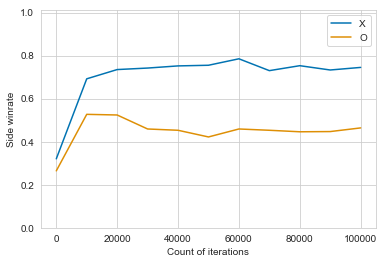

In [ ]:
agent = QAgent(env=TicTacToe(4, 4, 4))
result = agent.learn(n_train_episodes=100000, n_test_episodes=1000, verbose=10000, min_eps=0.05)
plot_results(agent, result)

Здесь все тоже выглядит разумно - игра не настолько выигрышная при правильной стратегии, но результаты все равно значит лучше случайных.

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).
- Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
- Реализуйте Double DQN и/или Dueling DQN.

Код, реализующий Q-обучение, реализован в модуле `dqn.py`.

В целом, идея очень похожа на Q-обучение, только теперь необходимо использовать две модели (хотя возможно, по аналогии с табличным обучением, в связи с тем, что состояния не пересекаются, можно было бы обойтись одной моделью, но ни к чему хорошему меня это не привело - впрочем, возможно, просто требовалось больше экспериментов) в связи с необходимостью более тонкой настройки модели.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dqn import AgentDQN


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Зададим структуру сети (брал немного параметров, чтобы обучалось побыстрее, сама архитектура является упрощенной версией описанной в [титориале](https://pythonprogramming.net/deep-q-learning-dqn-reinforcement-learning-python-tutorial/).

In [3]:
class DQN_3v3(nn.Module):
    def __init__(
        self,
        input_dim=3,
        output_dim=9,
        hidden_dim=64):
        super(DQN_3v3, self).__init__()
        self.c1 = nn.Conv2d(input_dim, hidden_dim * 2, (3, 3))
        self.l1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


Посмотрим, что выходит на доске 3х3:

Final X win rate:  0.869
Final O win rate:  0.775


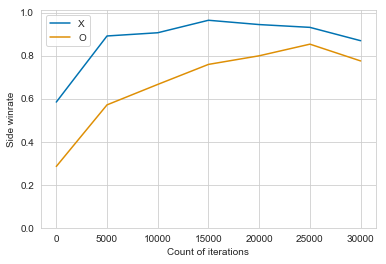

In [9]:
d_agent = AgentDQN(model=DQN_3v3)
result = d_agent.learn(n_train_episodes=30000, n_test_episodes=1000, verbose=5000, min_eps=0)
plot_results(d_agent, result)

Видно, что получается неплохо, хотя кажется, модель немного не доучилась относительно табличного метода.

Проделаем то же самое для доски 4х4:

In [10]:
class DQN_4v4(nn.Module):
    def __init__(
        self,
        input_dim=3,
        output_dim=16):
        super(DQN_4v4, self).__init__()
        self.c1 = nn.Conv2d(input_dim, 16, (3, 3))
        self.c2 = nn.Conv2d(16, 256, (2, 2))
        self.l1 = nn.Linear(256, 128)
        self.l2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

Final X win rate:  0.833
Final O win rate:  0.628


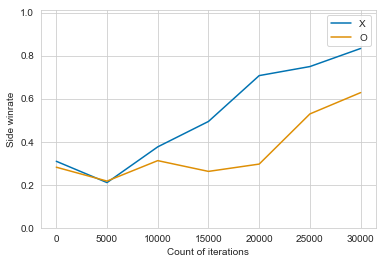

In [17]:
d_agent = AgentDQN(model=DQN_4v4, env=TicTacToe(4, 4, 4))
result = d_agent.learn(n_train_episodes=30000, n_test_episodes=1000, verbose=5000, min_eps=0)
plot_results(d_agent, result)

А вот здесь результаты получились лучше, чем в табличном обучении, хотя по времени модель обучалась значительно дольше.

Теперь реализуем dueling network. Функциональность и пример сети хорошо описаны  [здесь](https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751), реализация на подобии ранее использованных.

In [18]:
class DuelingDQN(nn.Module):
    def __init__(
        self,
        input_dim=3,
        output_dim=9,
        hidden_dim=64):
        super(DuelingDQN, self).__init__()
        self.conv = nn.Conv2d(input_dim, hidden_dim * 2, (3, 3))
        self.l = nn.Linear(hidden_dim * 2, hidden_dim)
        self.val = nn.Linear(hidden_dim, 1)
        self.adv = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l(x))
        val = self.val(x)
        adv = self.adv(x)
        return val + (adv - adv.mean(dim=1, keepdim=True))

Проверим работоспособность на маленькой доске 3x3:

100%|██████████| 30000/30000 [20:17<00:00, 24.65it/s]


Final X win rate:  0.972
Final O win rate:  0.874


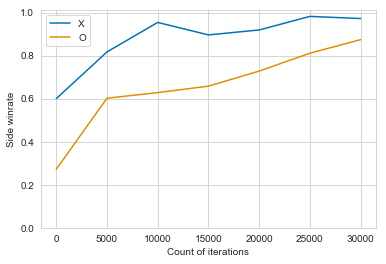

In [19]:
d_agent = AgentDQN(model=DuelingDQN)
result = d_agent.learn(n_train_episodes=30000, n_test_episodes=1000, verbose=5000, min_eps=0)
plot_results(d_agent, result)

Отметим, что при равном количестве итераций, dueling network показала результат значительно лучше обычной, и даже несколько превзошла табличное обучение.

# Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.
- Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
- Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.


Код для реализации MCTS находится в модуле `mcts.py`, внутри которого реализованы rollouts со случайной стратегией. В качестве образца бралась [статья](https://www.geeksforgeeks.org/ml-monte-carlo-tree-search-mcts/).

In [1]:
from mcts import MCTSAgent

Запустим небольшое число роллаутов на маленькой доске (здесь итераций заметно меньше, однако для каждого эпизода проводится 100 симуляций):

In [5]:
mc_agent = MCTSAgent(TicTacToe(3, 3, 3))
mc_agent.learn(n_test_episodes=500);

Final X win rate:  0.932
Final O win rate:  0.604


Результаты весьма впечатляющие, хотя по ощущениям, нолики немного недоучены в сравнении с другими моделями.

Посмотрим на результаты на доске 4х4:

In [8]:
mc_agent = MCTSAgent(TicTacToe(4, 4, 4))
mc_agent.learn(n_test_episodes=500);

Final X win rate:  0.792
Final O win rate:  0.742


Результат приятно удивляет. Крестики чуть хуже чем у DQN, зато получше чувствуют себя нолики, и все это при значительно меньшем времени на обучение.

# Выводы

- Были рассмотрены и реализованы различные модели обучения с подкреплением для задачи - табличное Q-обучение, DQN и Dueling DQN, а также MCTS;

- Результаты во многом зависят от времени, затраченного на обучение, из-за чего сравнивать их в поединке между собой довольно непросто. Однако каждая из них показала результаты значительно превосходящие случайные стратегии;

- Для доски 3х3 любая из стратегий достаточно легко находит нужную стратегию за каждую из сторон. Для доски 4х4 MCTS и DQN показали себя чуть лучше Q-обучения, при этом MCTS обучился примерно в 7 раз быстрее.